# DATA 572 Project

1. Data loading & split
2. Preprocessing (shared)
3. Models (Logistic, KNN, Random Forest)
4. Evaluation & comparison




In [1]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)


## 1. Load data

In [2]:
# Load dataset
df = pd.read_csv("titanic_augmented.csv")
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,is_alone,ticket_group_size,fare_per_person,age_fare_ratio,cabin_deck,cabin_room_number,booking_reference,service_id,cabin_score,name_word_count
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,7.250,3.034483,Unknown,NaN,92490,221958,6.134152,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,71.283,0.533084,C,85.0,15655423,771155,4.182430,7
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,7.925,3.280757,Unknown,NaN,90218500,231932,9.327285,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,2,26.550,0.659134,C,123.0,2493079,465838,8.660639,7
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,1,8.050,4.347826,Unknown,NaN,59517148,359178,0.452187,4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        891 non-null    int64  
 1   Survived           891 non-null    int64  
 2   Pclass             891 non-null    int64  
 3   Name               891 non-null    object 
 4   Sex                891 non-null    object 
 5   Age                714 non-null    float64
 6   SibSp              891 non-null    int64  
 7   Parch              891 non-null    int64  
 8   Ticket             891 non-null    object 
 9   Fare               891 non-null    float64
 10  Cabin              204 non-null    object 
 11  Embarked           889 non-null    object 
 12  name_length        891 non-null    int64  
 13  title              891 non-null    object 
 14  title_group        891 non-null    object 
 15  family_size        891 non-null    int64  
 16  is_alone           891 non

## 2. Feature selection and train/test split

In [4]:
SEED = 42
TARGET = "Survived"

# Columns that should NOT be used as predictors (IDs / leakage / raw text)
drop_cols = [
    "PassengerId", "Name", "Ticket", "Cabin",
    "booking_reference", "service_id"
]

# Create X, y
X = df.drop(columns=[TARGET] + [c for c in drop_cols if c in df.columns])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=SEED
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train survival rate:", y_train.mean().round(3))
print("Test survival rate :", y_test.mean().round(3))


Train shape: (668, 19)  Test shape: (223, 19)
Train survival rate: 0.383
Test survival rate : 0.386


## 3. Shared preprocessing pipeline

In [5]:
# Detect numeric vs categorical columns from the TRAIN set
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric features:", len(num_features))
print("Categorical features:", len(cat_features))


Numeric features: 14
Categorical features: 5


In [6]:
# Shared preprocessor used by all models (for fair comparison)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop",
)

# Sanity-check (optional)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("Processed train shape:", X_train_processed.shape)
print("Processed test shape :", X_test_processed.shape)


Processed train shape: (668, 46)
Processed test shape : (223, 46)


# 4. Model A — Logistic Regression (Full feature set)

In [7]:
# Logistic Regression pipeline + CV tuning
logreg_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(solver="liblinear", max_iter=2000, random_state=SEED))
])

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

param_grid_logreg = {
    "model__penalty": ["l1", "l2"],
    "model__C": [0.01, 0.1, 1, 10],
}

grid_logreg = GridSearchCV(
    logreg_pipe,
    param_grid=param_grid_logreg,
    cv=cv5,
    scoring="roc_auc",
    n_jobs=-1,
)

grid_logreg.fit(X_train, y_train)

best_logreg = grid_logreg.best_estimator_
print("Best params (LogReg full):", grid_logreg.best_params_)
print("Best CV ROC AUC (LogReg full):", grid_logreg.best_score_)


Best params (LogReg full): {'model__C': 1, 'model__penalty': 'l1'}
Best CV ROC AUC (LogReg full): 0.8666237292177208


In [8]:
# Final test evaluation (LogReg full)
y_pred_full = best_logreg.predict(X_test)
y_prob_full = best_logreg.predict_proba(X_test)[:, 1]

metrics_full = {
    "Accuracy": accuracy_score(y_test, y_pred_full),
    "Precision": precision_score(y_test, y_pred_full),
    "Recall": recall_score(y_test, y_pred_full),
    "F1": f1_score(y_test, y_pred_full),
    "ROC AUC": roc_auc_score(y_test, y_prob_full),
}
metrics_full


{'Accuracy': 0.8295964125560538,
 'Precision': 0.7790697674418605,
 'Recall': 0.7790697674418605,
 'F1': 0.7790697674418605,
 'ROC AUC': np.float64(0.8583432354438975)}

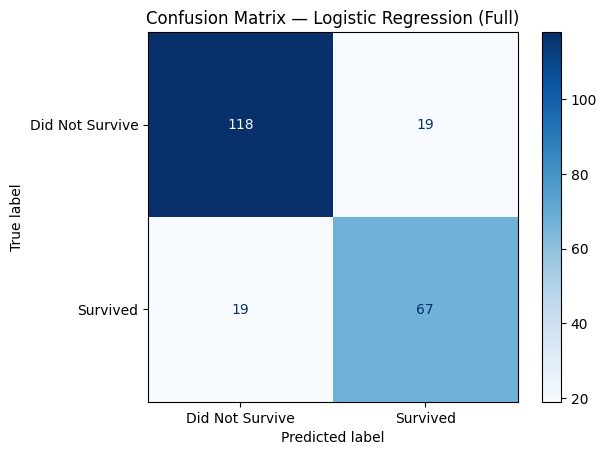

In [9]:
# Confusion matrix (LogReg full)
cm = confusion_matrix(y_test, y_pred_full)
disp = ConfusionMatrixDisplay(cm, display_labels=["Did Not Survive", "Survived"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression (Full)")
plt.show()


## 4A. Interpretation (LogReg full) — odds ratios

In [10]:
# Build coefficient table
ohe = (best_logreg.named_steps["preprocess"]
       .named_transformers_["cat"]
       .named_steps["onehot"])

feature_names = (
    list(num_features) +
    list(ohe.get_feature_names_out(cat_features))
)

coefs = best_logreg.named_steps["model"].coef_[0]

coef_df_full = (pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "odds_ratio": np.exp(coefs),
})
.sort_values("odds_ratio", ascending=False))

display(coef_df_full.head(10))
display(coef_df_full.tail(10).sort_values("odds_ratio"))


,feature,coef,odds_ratio
14,Sex_female,1.676755,5.348174
40,cabin_deck_D,0.931281,2.537757
32,title_group_Master,0.907336,2.477712
41,cabin_deck_E,0.710120,2.034235
25,title_Master,0.589673,1.803399
4,Fare,0.408461,1.504500
35,title_group_Mrs,0.323619,1.382120
12,cabin_score,0.212829,1.237173
5,name_length,0.144612,1.155592
17,Embarked_Q,0.138369,1.148399


,feature,coef,odds_ratio
28,title_Mr,-1.026383,0.358301
45,cabin_deck_Unknown,-0.683502,0.504846
0,Pclass,-0.568119,0.566590
1,Age,-0.417937,0.658404
6,family_size,-0.400902,0.669716
18,Embarked_S,-0.330090,0.718859
30,title_Rev,-0.293296,0.745801
9,fare_per_person,-0.206427,0.813486
2,SibSp,-0.201366,0.817613
8,ticket_group_size,-0.125561,0.882002


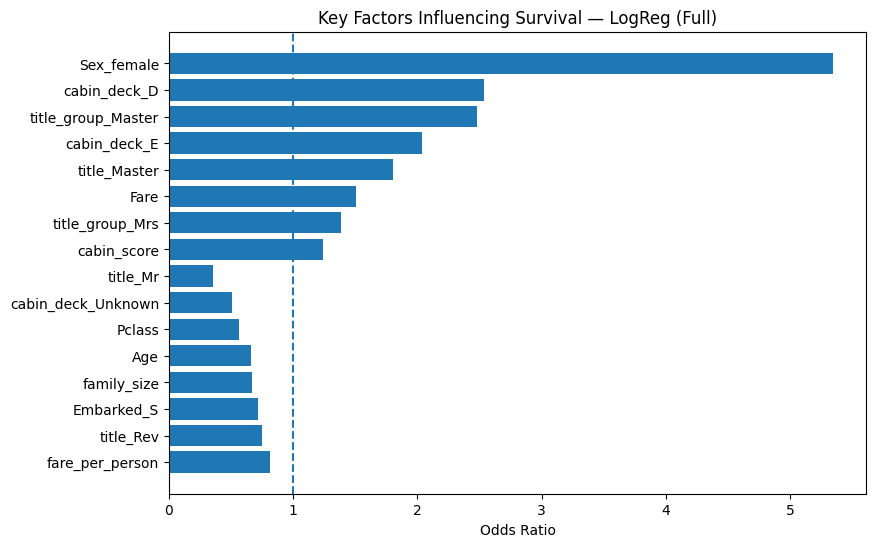

In [11]:
# Odds ratio plot (top + bottom effects)
top_pos = coef_df_full.sort_values("odds_ratio", ascending=False).head(8)
top_neg = coef_df_full.sort_values("odds_ratio", ascending=True).head(8)
plot_df = pd.concat([top_pos, top_neg])

plt.figure(figsize=(9, 6))
plt.barh(plot_df["feature"], plot_df["odds_ratio"])
plt.axvline(1, linestyle="--")
plt.xlabel("Odds Ratio")
plt.title("Key Factors Influencing Survival — LogReg (Full)")
plt.gca().invert_yaxis()
plt.show()


# 5. Model B — Logistic Regression (Simplified feature set)

In [12]:
# Choose a small, interpretable feature set (drop weak/redundant engineered columns)
drop_more = [
    "name_length",
    "name_word_count",
    "ticket_group_size",
    "fare_per_person",
    "age_fare_ratio",
    "cabin_room_number",
    "cabin_score",
    "title",  # keep title_group instead
]

X_simple = df.drop(columns=[TARGET] + [c for c in drop_cols if c in df.columns] + [c for c in drop_more if c in df.columns])
y_simple = df[TARGET].astype(int)

Xs_train, Xs_test, ys_train, ys_test = train_test_split(
    X_simple, y_simple,
    test_size=0.25,
    stratify=y_simple,
    random_state=SEED
)

# Detect feature types again (because columns changed)
num_features_s = Xs_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features_s = Xs_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

numeric_transformer_s = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer_s = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor_s = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_s, num_features_s),
        ("cat", categorical_transformer_s, cat_features_s),
    ],
    remainder="drop",
)


In [13]:
# CV-tuned simplified LogReg
logreg_simple_pipe = Pipeline([
    ("preprocess", preprocessor_s),
    ("model", LogisticRegression(solver="liblinear", max_iter=2000, random_state=SEED)),
])

grid_logreg_simple = GridSearchCV(
    logreg_simple_pipe,
    param_grid=param_grid_logreg,
    cv=cv5,
    scoring="roc_auc",
    n_jobs=-1,
)

grid_logreg_simple.fit(Xs_train, ys_train)
best_logreg_simple = grid_logreg_simple.best_estimator_

print("Best params (LogReg simple):", grid_logreg_simple.best_params_)
print("Best CV ROC AUC (LogReg simple):", grid_logreg_simple.best_score_)


Best params (LogReg simple): {'model__C': 1, 'model__penalty': 'l1'}
Best CV ROC AUC (LogReg simple): 0.8694397056274983


In [14]:
# Final test evaluation (LogReg simple)
y_pred_simple = best_logreg_simple.predict(Xs_test)
y_prob_simple = best_logreg_simple.predict_proba(Xs_test)[:, 1]

metrics_simple = {
    "Accuracy": accuracy_score(ys_test, y_pred_simple),
    "Precision": precision_score(ys_test, y_pred_simple),
    "Recall": recall_score(ys_test, y_pred_simple),
    "F1": f1_score(ys_test, y_pred_simple),
    "ROC AUC": roc_auc_score(ys_test, y_prob_simple),
}
metrics_simple


{'Accuracy': 0.820627802690583,
 'Precision': 0.7613636363636364,
 'Recall': 0.7790697674418605,
 'F1': 0.7701149425287356,
 'ROC AUC': np.float64(0.8685707010694279)}

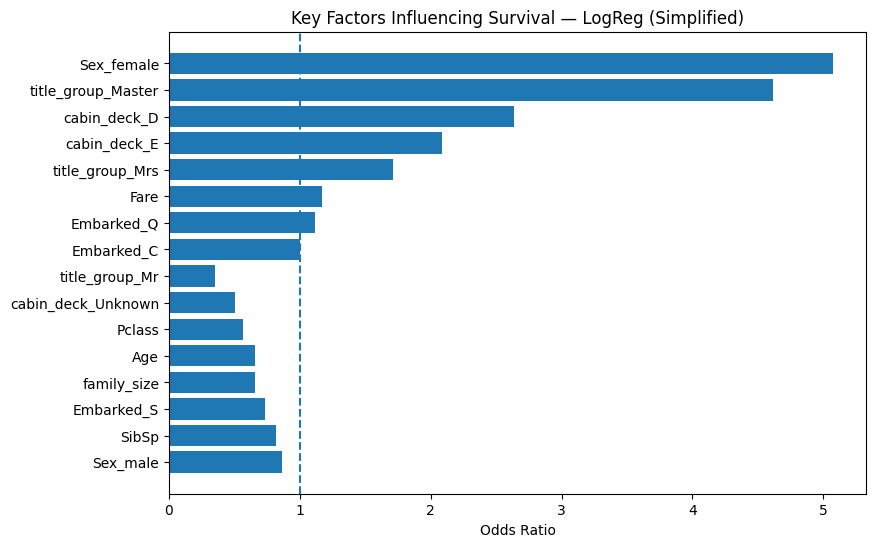

In [15]:
# Interpretation plot (LogReg simple)
ohe_s = (best_logreg_simple.named_steps["preprocess"]
         .named_transformers_["cat"]
         .named_steps["onehot"])

feature_names_s = list(num_features_s) + list(ohe_s.get_feature_names_out(cat_features_s))
coefs_s = best_logreg_simple.named_steps["model"].coef_[0]

coef_df_simple = (pd.DataFrame({
    "feature": feature_names_s,
    "coef": coefs_s,
    "odds_ratio": np.exp(coefs_s)
}).sort_values("odds_ratio", ascending=False))

top_pos = coef_df_simple.head(8)
top_neg = coef_df_simple.sort_values("odds_ratio", ascending=True).head(8)
plot_df = pd.concat([top_pos, top_neg])

plt.figure(figsize=(9, 6))
plt.barh(plot_df["feature"], plot_df["odds_ratio"])
plt.axvline(1, linestyle="--")
plt.xlabel("Odds Ratio")
plt.title("Key Factors Influencing Survival — LogReg (Simplified)")
plt.gca().invert_yaxis()
plt.show()


## 5A. Threshold analysis (LogReg simple)

In [16]:
# Compare default threshold (0.50) vs adjusted threshold (0.45)
thr_default = 0.50
thr_adjusted = 0.45

y_pred_simple_05 = (y_prob_simple >= thr_default).astype(int)
y_pred_simple_045 = (y_prob_simple >= thr_adjusted).astype(int)

metrics_simple_045 = {
    "Accuracy": accuracy_score(ys_test, y_pred_simple_045),
    "Precision": precision_score(ys_test, y_pred_simple_045),
    "Recall": recall_score(ys_test, y_pred_simple_045),
    "F1": f1_score(ys_test, y_pred_simple_045),
    "ROC AUC": roc_auc_score(ys_test, y_prob_simple),  # threshold-independent
}
metrics_simple_045


{'Accuracy': 0.8161434977578476,
 'Precision': 0.7472527472527473,
 'Recall': 0.7906976744186046,
 'F1': 0.768361581920904,
 'ROC AUC': np.float64(0.8685707010694279)}

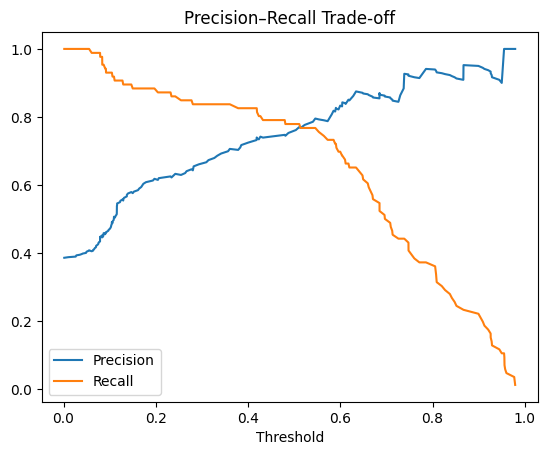

In [17]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(ys_test, y_prob_simple)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision–Recall Trade-off")
plt.show()


# 6. Model C — KNN

In [18]:
# KNN (Full feature set): pipeline + CV tuning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

knn_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", KNeighborsClassifier()),
])

param_grid_knn = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2],  # 1=Manhattan, 2=Euclidean
}

grid_knn = GridSearchCV(
    knn_pipe,
    param_grid=param_grid_knn,
    cv=cv5,
    scoring="roc_auc",
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_

print("Best params:", grid_knn.best_params_)
print("Best CV ROC AUC:", grid_knn.best_score_)


Best params: {'model__n_neighbors': 21, 'model__p': 1, 'model__weights': 'distance'}
Best CV ROC AUC: 0.8722242573649636


In [19]:
# Final test evaluation (KNN full)
y_pred_knn = best_knn.predict(X_test)
y_prob_knn = best_knn.predict_proba(X_test)[:, 1]

metrics_knn = {
    "Accuracy": accuracy_score(y_test, y_pred_knn),
    "Precision": precision_score(y_test, y_pred_knn),
    "Recall": recall_score(y_test, y_pred_knn),
    "F1": f1_score(y_test, y_pred_knn),
    "ROC AUC": roc_auc_score(y_test, y_prob_knn),
}
metrics_knn


C:\Users\yinwe\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\yinwe\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\yinwe\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yinwe\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^

{'Accuracy': 0.8251121076233184,
 'Precision': 0.8051948051948052,
 'Recall': 0.7209302325581395,
 'F1': 0.7607361963190185,
 'ROC AUC': np.float64(0.8496859616363945)}

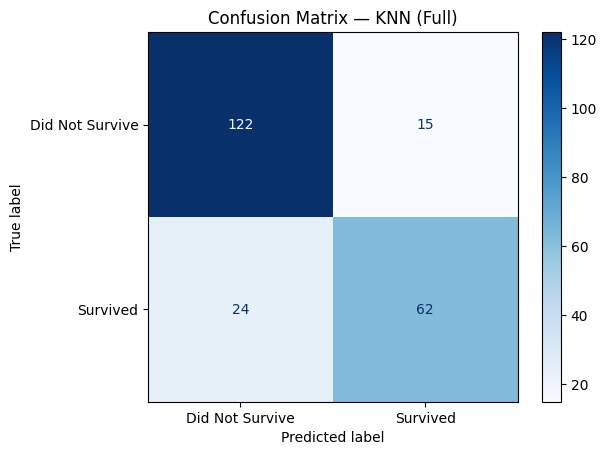

In [20]:
# Confusion Matrix — KNN full (thr=0.50)
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — KNN (Full)")
plt.show()


## 6A. Interpretation (KNN full) — permutation importance (for feature pruning)

In [21]:
# KNN is not inherently interpretable; use permutation importance on a held-out validation split
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.20,
    stratify=y_train,
    random_state=SEED
)

# Refit tuned grid on X_tr only (avoid peeking at full training)
grid_knn.fit(X_tr, y_tr)
best_knn_interp = grid_knn.best_estimator_

perm = permutation_importance(
    best_knn_interp,
    X_val,
    y_val,
    n_repeats=10,
    random_state=SEED,
    scoring="roc_auc"
)

perm_imp = pd.Series(perm.importances_mean, index=X_val.columns).sort_values(ascending=True)

# Bottom-k least useful features (candidate drops for KNN)
k = 8
drop_by_perm = perm_imp.head(k).index.tolist()

# KNN-sensitive heuristics: high missingness, redundant numeric features (high correlation)
missing_rate = X_train.isna().mean()
high_missing_cols = missing_rate[missing_rate > 0.40].index.tolist()

num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
high_corr_drop = []
if len(num_cols) > 1:
    corr_df = X_train[num_cols].copy().fillna(X_train[num_cols].median(numeric_only=True))
    corr_mat = corr_df.corr().abs()
    upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
    high_pairs = [(i, j, upper.loc[i, j]) for i in upper.index for j in upper.columns
                  if pd.notna(upper.loc[i, j]) and upper.loc[i, j] > 0.90]
    for a, b, v in high_pairs:
        drop_one = a if missing_rate.get(a, 0) >= missing_rate.get(b, 0) else b
        high_corr_drop.append(drop_one)
    high_corr_drop = sorted(list(set(high_corr_drop)))

drop_more_knn = sorted(list(set(drop_by_perm + high_missing_cols + high_corr_drop)))

print("\n=== KNN Interpretation Summary ===")
print("Bottom-k by permutation importance:", drop_by_perm)
print("High-missing (>40%) columns:", high_missing_cols)
print("High-correlation drop suggestions:", high_corr_drop)
print("Final drop_more_knn (KNN):", drop_more_knn)



=== KNN Interpretation Summary ===
Bottom-k by permutation importance: ['cabin_score', 'Embarked', 'age_fare_ratio', 'fare_per_person', 'title', 'title_group', 'cabin_room_number', 'name_length']
High-missing (>40%) columns: ['cabin_room_number']
High-correlation drop suggestions: ['name_length']
Final drop_more_knn (KNN): ['Embarked', 'age_fare_ratio', 'cabin_room_number', 'cabin_score', 'fare_per_person', 'name_length', 'title', 'title_group']


# 6B. KNN (Simplified feature set)

In [22]:
# Simplified KNN: use a reduced feature set (from KNN notebook) to reduce noise for distance-based model
drop_more_knn_fixed = [
    "Embarked",
    "age_fare_ratio",
    "cabin_room_number",
    "cabin_score",
    "fare_per_person",
    "name_length",
    "title",
    "title_group",
]

Xk_simple = df.drop(columns=[TARGET] + [c for c in drop_cols if c in df.columns] + [c for c in drop_more_knn_fixed if c in df.columns])
yk_simple = df[TARGET].astype(int)

Xk_train, Xk_test, yk_train, yk_test = train_test_split(
    Xk_simple, yk_simple,
    test_size=0.25,
    stratify=yk_simple,
    random_state=SEED
)

# Detect types again
num_features_k = Xk_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features_k = Xk_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

numeric_transformer_k = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer_k = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor_k = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_k, num_features_k),
        ("cat", categorical_transformer_k, cat_features_k),
    ],
    remainder="drop",
)

knn_simple = Pipeline([
    ("preprocess", preprocessor_k),
    ("model", KNeighborsClassifier()),
])

grid_knn_simple = GridSearchCV(
    knn_simple,
    param_grid=param_grid_knn,
    cv=cv5,
    scoring="roc_auc",
    n_jobs=-1
)

grid_knn_simple.fit(Xk_train, yk_train)
best_knn_simple = grid_knn_simple.best_estimator_

print("Best params (simple):", grid_knn_simple.best_params_)
print("Best CV ROC AUC (simple):", grid_knn_simple.best_score_)


Best params (simple): {'model__n_neighbors': 15, 'model__p': 1, 'model__weights': 'uniform'}
Best CV ROC AUC (simple): 0.8616621878752179


In [23]:
# Final test evaluation (KNN simplified)
yk_pred_knn = best_knn_simple.predict(Xk_test)
yk_prob_knn = best_knn_simple.predict_proba(Xk_test)[:, 1]

metrics_knn_simple = {
    "Accuracy": accuracy_score(yk_test, yk_pred_knn),
    "Precision": precision_score(yk_test, yk_pred_knn),
    "Recall": recall_score(yk_test, yk_pred_knn),
    "F1": f1_score(yk_test, yk_pred_knn),
    "ROC AUC": roc_auc_score(yk_test, yk_prob_knn),
}
metrics_knn_simple


{'Accuracy': 0.7802690582959642,
 'Precision': 0.7605633802816901,
 'Recall': 0.627906976744186,
 'F1': 0.6878980891719745,
 'ROC AUC': np.float64(0.8358512985910711)}

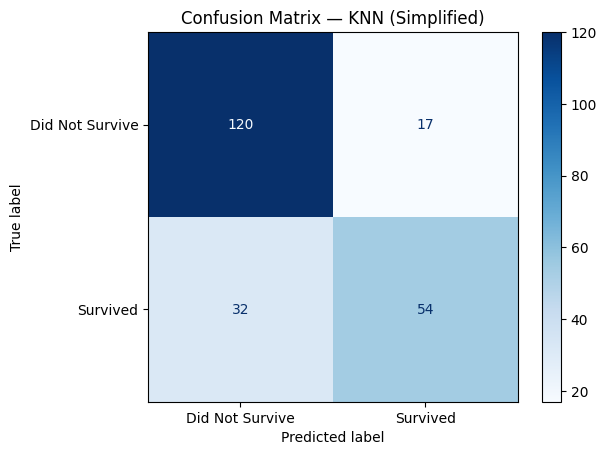

In [24]:
# Confusion Matrix — KNN simplified (thr=0.50)
cm = confusion_matrix(yk_test, yk_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — KNN (Simplified)")
plt.show()


## 6C. Threshold analysis (KNN simplified)

In [25]:
# Adjust decision threshold (example: 0.45)
threshold = 0.45
yk_pred_knn_045 = (yk_prob_knn >= threshold).astype(int)

print("Accuracy :", accuracy_score(yk_test, yk_pred_knn_045))
print("Recall   :", recall_score(yk_test, yk_pred_knn_045))
print("Precision:", precision_score(yk_test, yk_pred_knn_045))


Accuracy : 0.7713004484304933
Recall   : 0.7325581395348837
Precision: 0.6923076923076923


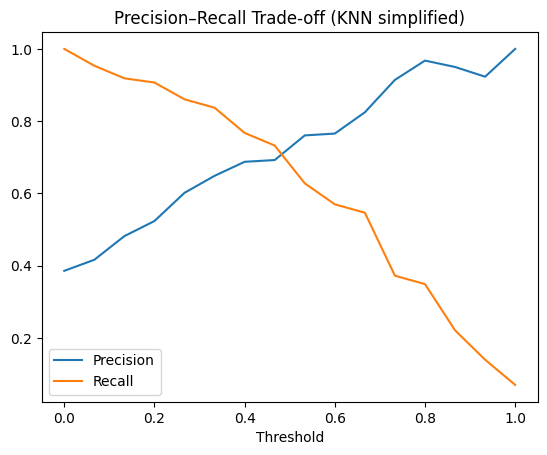

In [26]:
# Precision–Recall trade-off (KNN simplified)
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(yk_test, yk_prob_knn)
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision–Recall Trade-off (KNN simplified)")
plt.show()


In [27]:
# Summary table (KNN variants)
knn_results = pd.DataFrame([
    {
        "Model": "Full KNN (thr=0.50)",
        "Accuracy": accuracy_score(y_test, y_pred_knn),
        "Precision": precision_score(y_test, y_pred_knn),
        "Recall": recall_score(y_test, y_pred_knn),
        "F1": f1_score(y_test, y_pred_knn),
        "ROC AUC": roc_auc_score(y_test, y_prob_knn),
    },
    {
        "Model": "Simplified KNN reduced features (thr=0.50)",
        "Accuracy": accuracy_score(yk_test, yk_pred_knn),
        "Precision": precision_score(yk_test, yk_pred_knn),
        "Recall": recall_score(yk_test, yk_pred_knn),
        "F1": f1_score(yk_test, yk_pred_knn),
        "ROC AUC": roc_auc_score(yk_test, yk_prob_knn),
    },
    {
        "Model": "Simplified KNN (thr=0.45)",
        "Accuracy": accuracy_score(yk_test, yk_pred_knn_045),
        "Precision": precision_score(yk_test, yk_pred_knn_045),
        "Recall": recall_score(yk_test, yk_pred_knn_045),
        "F1": f1_score(yk_test, yk_pred_knn_045),
        "ROC AUC": roc_auc_score(yk_test, yk_prob_knn),
    },
]).round(3)

knn_results


,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,Full KNN (thr=0.50),0.825,0.805,0.721,0.761,0.850
1,Simplified KNN reduced features (thr=0.50),0.780,0.761,0.628,0.688,0.836
2,Simplified KNN (thr=0.45),0.771,0.692,0.733,0.712,0.836


# 7. Model D — Random Forest

In [28]:
# Random Forest (Full feature set): pipeline + CV tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

rf_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(random_state=SEED, n_jobs=-1)),
])

param_grid_rf = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 4, 6, 8, 10],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__max_features": ["sqrt", "log2", None],
}

grid_rf = GridSearchCV(
    rf_pipe,
    param_grid=param_grid_rf,
    cv=cv5,
    scoring="roc_auc",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

print("Best params:", grid_rf.best_params_)
print("Best CV ROC AUC:", grid_rf.best_score_)


Best params: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__n_estimators': 600}
Best CV ROC AUC: 0.8848870927923148


In [29]:
# Final test evaluation (RF full)
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

metrics_rf = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1": f1_score(y_test, y_pred_rf),
    "ROC AUC": roc_auc_score(y_test, y_prob_rf),
}
metrics_rf


{'Accuracy': 0.7937219730941704,
 'Precision': 0.7439024390243902,
 'Recall': 0.7093023255813954,
 'F1': 0.7261904761904762,
 'ROC AUC': np.float64(0.8576642335766422)}

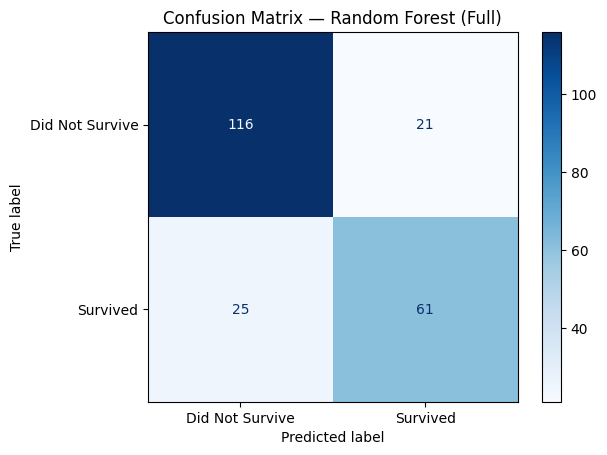

In [30]:
# Confusion Matrix — RF full (thr=0.50)
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Random Forest (Full)")
plt.show()


# 7B. Random Forest (Simplified feature set)

In [31]:
# Simplified RF: reduced engineered features (match RF notebook)
drop_more_rf = [
    "name_word_count",
    "ticket_group_size",
    "cabin_room_number",
    "family_size",
]

Xr_simple = df.drop(columns=[TARGET] + [c for c in drop_cols if c in df.columns] + [c for c in drop_more_rf if c in df.columns])
yr_simple = df[TARGET].astype(int)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr_simple, yr_simple,
    test_size=0.25,
    stratify=yr_simple,
    random_state=SEED
)

num_features_r = Xr_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features_r = Xr_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

numeric_transformer_r = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer_r = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor_r = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_r, num_features_r),
        ("cat", categorical_transformer_r, cat_features_r),
    ],
    remainder="drop",
)

rf_simple = Pipeline([
    ("preprocess", preprocessor_r),
    ("model", RandomForestClassifier(random_state=SEED, n_jobs=-1)),
])

grid_rf_simple = GridSearchCV(
    rf_simple,
    param_grid=param_grid_rf,
    cv=cv5,
    scoring="roc_auc",
    n_jobs=-1
)

grid_rf_simple.fit(Xr_train, yr_train)
best_rf_simple = grid_rf_simple.best_estimator_

print("Best params (simple):", grid_rf_simple.best_params_)
print("Best CV ROC AUC (simple):", grid_rf_simple.best_score_)


Best params (simple): {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__n_estimators': 400}
Best CV ROC AUC (simple): 0.8772782000975982


In [32]:
# Final test evaluation (RF simplified)
yr_pred_rf = best_rf_simple.predict(Xr_test)
yr_prob_rf = best_rf_simple.predict_proba(Xr_test)[:, 1]

metrics_rf_simple = {
    "Accuracy": accuracy_score(yr_test, yr_pred_rf),
    "Precision": precision_score(yr_test, yr_pred_rf),
    "Recall": recall_score(yr_test, yr_pred_rf),
    "F1": f1_score(yr_test, yr_pred_rf),
    "ROC AUC": roc_auc_score(yr_test, yr_prob_rf),
}
metrics_rf_simple


{'Accuracy': 0.8116591928251121,
 'Precision': 0.7894736842105263,
 'Recall': 0.6976744186046512,
 'F1': 0.7407407407407407,
 'ROC AUC': np.float64(0.8584281106773044)}

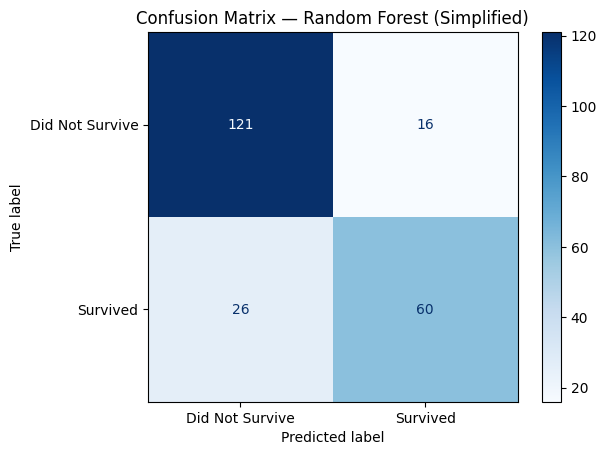

In [33]:
# Confusion Matrix — RF simplified (thr=0.50)
cm = confusion_matrix(yr_test, yr_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Random Forest (Simplified)")
plt.show()


## 7C. Feature importance (RF simplified)

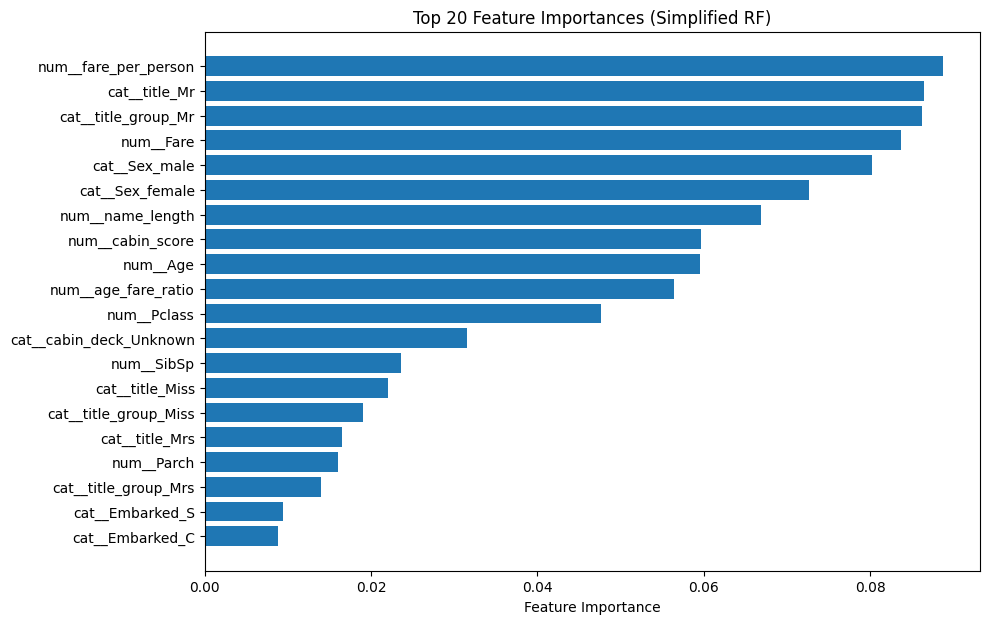

In [34]:
# Feature names after preprocessing (one-hot, etc.)
feature_names_r = best_rf_simple.named_steps["preprocess"].get_feature_names_out()
importances_r = best_rf_simple.named_steps["model"].feature_importances_

imp_df_r = pd.DataFrame({
    "feature": feature_names_r,
    "importance": importances_r
}).sort_values("importance", ascending=False)

# plot top 20
plot_df = imp_df_r.head(20).iloc[::-1]

plt.figure(figsize=(10, 7))
plt.barh(plot_df["feature"], plot_df["importance"])
plt.xlabel("Feature Importance")
plt.title("Top 20 Feature Importances (Simplified RF)")
plt.show()


## 7D. Threshold analysis (RF simplified)

In [35]:
threshold = 0.45
yr_pred_rf_045 = (yr_prob_rf >= threshold).astype(int)

print("Accuracy :", accuracy_score(yr_test, yr_pred_rf_045))
print("Recall   :", recall_score(yr_test, yr_pred_rf_045))
print("Precision:", precision_score(yr_test, yr_pred_rf_045))


Accuracy : 0.8116591928251121
Recall   : 0.7441860465116279
Precision: 0.7619047619047619


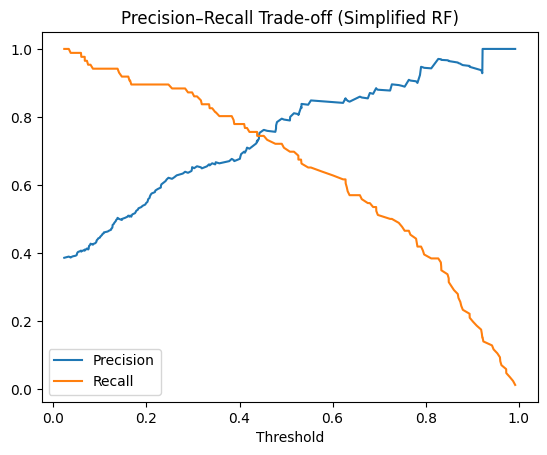

In [36]:
# Precision–Recall trade-off (RF simplified)
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(yr_test, yr_prob_rf)
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision–Recall Trade-off (Simplified RF)")
plt.show()


In [37]:
# Summary table (RF variants)
rf_results = pd.DataFrame([
    {
        "Model": "Full RF (thr=0.50)",
        "Accuracy": accuracy_score(y_test, y_pred_rf),
        "Precision": precision_score(y_test, y_pred_rf),
        "Recall": recall_score(y_test, y_pred_rf),
        "F1": f1_score(y_test, y_pred_rf),
        "ROC AUC": roc_auc_score(y_test, y_prob_rf),
    },
    {
        "Model": "Simplified RF reduced features (thr=0.50)",
        "Accuracy": accuracy_score(yr_test, yr_pred_rf),
        "Precision": precision_score(yr_test, yr_pred_rf),
        "Recall": recall_score(yr_test, yr_pred_rf),
        "F1": f1_score(yr_test, yr_pred_rf),
        "ROC AUC": roc_auc_score(yr_test, yr_prob_rf),
    },
    {
        "Model": "Simplified RF (thr=0.45)",
        "Accuracy": accuracy_score(yr_test, yr_pred_rf_045),
        "Precision": precision_score(yr_test, yr_pred_rf_045),
        "Recall": recall_score(yr_test, yr_pred_rf_045),
        "F1": f1_score(yr_test, yr_pred_rf_045),
        "ROC AUC": roc_auc_score(yr_test, yr_prob_rf),
    },
]).round(3)

rf_results


,Model,Accuracy,Precision,Recall,F1,ROC AUC
0,Full RF (thr=0.50),0.794,0.744,0.709,0.726,0.858
1,Simplified RF reduced features (thr=0.50),0.812,0.789,0.698,0.741,0.858
2,Simplified RF (thr=0.45),0.812,0.762,0.744,0.753,0.858


# 8. Comparison table (3 logistic versions + KNN + RF)

In [38]:
# Build a single comparison table
comparison = pd.DataFrame([
    #{"Model": "LogReg Full (thr=0.50)", **metrics_full},
    {"Model": "LogReg Simple (thr=0.50)", **metrics_simple, "Interpretability": "High", "Complexity": "Low"},
    #{"Model": "LogReg Simple (thr=0.45)", **metrics_simple_045},
    {"Model": "KNN (thr=0.50)", **metrics_knn, "Interpretability": "Low", "Complexity": "Medium"},
    {"Model": "Random Forest (thr=0.50)", **metrics_rf, "Interpretability": "Medium", "Complexity": "High"}
])

comparison = comparison[["Model", "Accuracy", "Precision", "Recall", "F1", "ROC AUC", "Interpretability", "Complexity"]]
comparison.round(3)


,Model,Accuracy,Precision,Recall,F1,ROC AUC,Interpretability,Complexity
0,LogReg Simple (thr=0.50),0.821,0.761,0.779,0.770,0.869,High,Low
1,KNN (thr=0.50),0.825,0.805,0.721,0.761,0.850,Low,Medium
2,Random Forest (thr=0.50),0.794,0.744,0.709,0.726,0.858,Medium,High


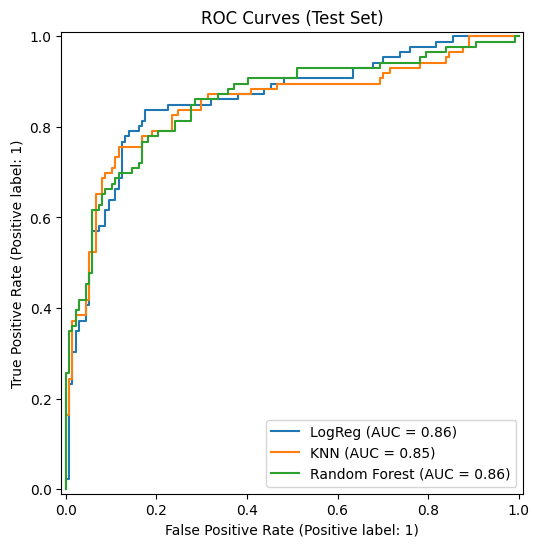

In [39]:
# Optional: ROC curves on the same plot (LogReg simple vs KNN vs RF)
plt.figure(figsize=(7, 6))
RocCurveDisplay.from_predictions(ys_test, y_prob_full, name="LogReg", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_prob_knn, name="KNN", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_prob_rf, name="Random Forest", ax=plt.gca())
plt.title("ROC Curves (Test Set)")
plt.show()
